In [50]:
import pandas as pd
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
import numpy as np
import re

In [52]:
data = pd.read_csv(r'..\preprocessing\tidy_data.csv', encoding = 'utf-8-sig')

In [54]:
data = data.dropna()

In [56]:
# Số dòng và cột của dữ liệu
data.shape

(10671, 26)

In [58]:
# Các thuộc tính của dữ liệu
data.columns

Index(['name', 'brand', 'condition', 'price_old', 'price_new', 'warranty',
       'CPU', 'RAM', 'capacity', 'time', 'battery', 'screen_size',
       'operating_system', 'display_technology', 'screen_resolution', 'weight',
       'bluetooth', 'refresh_rate', 'GPU', 'color', 'image', 'has_nano_sim',
       'has_esim', 'height', 'width', 'depth'],
      dtype='object')

In [60]:
data.describe()

,price_old,price_new,RAM,capacity,battery,screen_size,screen_resolution,weight,refresh_rate,has_nano_sim,has_esim,height,width,depth
count,1.067100e+04,1.067100e+04,10671.000000,10671.000000,10671.000000,10671.000000,1.067100e+04,10671.000000,10671.000000,10671.0,10671.000000,10671.000000,10671.000000,10671.000000
mean,8.723829e+06,1.390638e+07,7.816928,225.581717,4626.371099,6.351810,2.492312e+06,188.707291,98.963171,1.0,0.408865,158.305760,75.445859,11.225173
std,6.882816e+06,1.089597e+07,3.353882,150.174676,1061.713865,1.114018,1.103080e+06,25.478794,27.996774,0.0,0.491647,12.042844,10.999669,13.329651
min,1.500000e+05,4.100000e+05,0.046875,0.125000,1000.000000,1.770000,1.920000e+04,75.000000,30.000000,1.0,0.000000,71.500000,7.000000,5.000000
25%,3.110000e+06,4.690000e+06,6.000000,128.000000,4383.000000,6.560000,1.188000e+06,182.000000,90.000000,1.0,0.000000,157.900000,74.700000,7.680000
50%,7.050000e+06,1.029000e+07,8.000000,256.000000,5000.000000,6.670000,2.592000e+06,192.000000,120.000000,1.0,0.000000,162.200000,76.000000,7.900000
75%,1.270000e+07,2.299000e+07,12.000000,256.000000,5030.000000,6.700000,3.204000e+06,198.000000,120.000000,1.0,1.000000,165.100000,77.300000,8.300000
max,3.707000e+07,4.799000e+07,16.000000,1024.000000,6600.000000,7.600000,4.608000e+06,240.000000,144.000000,1.0,1.000000,191.900000,132.600000,88.900000


# Tính khoảng thời gian điện thoại đã ra mắt

In [63]:
data['time'] = pd.to_datetime(data['time'])

In [65]:
# Tính toán khoảng thời gian hiện tại - 'time'
data['time_difference'] = datetime.now() - data['time']
data['time_difference'] = data['time_difference'].dt.days

In [67]:
data.drop(columns=['time'], inplace=True)

# Tính thời gian hết bảo hành

In [70]:
processed_results = []
current_date = datetime.now() # Lấy ngày và giờ hiện tại

for index, item in data['warranty'].items():
    item = str(item).strip() # Đảm bảo item là chuỗi và loại bỏ khoảng trắng

    # Kiểm tra nếu có chứa "tháng"
    if "tháng" in item:
        num_months_str = item.replace("tháng", "").strip()
        num_months = int(num_months_str)

        # Xử lý cộng tháng
        year = current_date.year
        month = current_date.month + num_months
        day = current_date.day

        while month > 12:
            month -= 12
            year += 1
                
        # Xử lý trường hợp ngày không hợp lệ sau khi cộng tháng
        try:
            new_date = datetime(year, month, day)
        except ValueError:
            # Nếu ngày không hợp lệ, lấy ngày cuối cùng của tháng đó
            last_day_of_month = calendar.monthrange(year, month)[1]
            new_date = datetime(year, month, last_day_of_month)

        # Cập nhật giá trị
        data.loc[index, 'warranty'] = new_date.strftime("%d/%m/%Y")
    else:
            datetime.strptime(item, "%d/%m/%Y")
            data.loc[index, 'warranty'] = item 

# Chuyển dữ liệu sang kiểu datetime
data['warranty'] = pd.to_datetime(data['warranty'], format='%d/%m/%Y', errors='coerce')

In [71]:
# Tạo một Series mới cho current_date
current_date_series = pd.Series([current_date] * len(data))

# Tính hiệu số ngày
time_remaining = data['warranty'] - current_date_series

# Lưu vào một cột mới
data['day_remaining_warranty'] = time_remaining.dt.days + 1
data['day_remaining_warranty'] = data['day_remaining_warranty'].fillna(0)

In [72]:
data.drop(columns=['warranty'], inplace=True)

# Kiểm tra các thuộc tính object

In [74]:
from scipy.stats import entropy

categorical_columns = data.select_dtypes(include=['object']).columns

def calculate_entropy(data):
    entropy_values = {}
    for column in data.columns:
        probabilities = data[column].dropna().value_counts(normalize=True)
        entropy_values[column] = entropy(probabilities, base=2)
    return entropy_values

# Tính entropy cho từng thuộc tính
entropy_results = calculate_entropy(data[categorical_columns])
print(entropy_results)

{'name': 6.406648105149238, 'brand': 2.7872093113300602, 'condition': 0.44985345827128065, 'CPU': 5.145905350079112, 'operating_system': 2.752305097030987, 'display_technology': 2.7273137338749196, 'bluetooth': 2.3810610428044616, 'GPU': 4.286231183722029, 'color': 3.891287565185087, 'image': 13.381407759783006}


In [75]:
import scipy.stats as stats

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(r-1, k-1))

categorical_columns = data.select_dtypes(include=['object']).columns

# Tính Cramér's V giữa từng thuộc tính object và price_old
cramer_results = {col: cramers_v(data[col], data['price_old']) for col in categorical_columns}
print(cramer_results)

{'name': 0.8043509265194133, 'brand': 0.8819461456867734, 'condition': 0.7551487608034348, 'CPU': 0.7840877669391348, 'operating_system': 0.8461535309526166, 'display_technology': 0.7899982140534865, 'bluetooth': 0.7641148856615662, 'GPU': 0.803207680734552, 'color': 0.667166161404234, 'image': 1.0000000000000002}


In [76]:
categorical_columns = data.select_dtypes(include=['object']).columns

# Hàm kiểm định Kruskal-Wallis cho tất cả các biến phân loại với price_old
def kruskal_test(df, target):
    results = {}
    for col in categorical_columns:
        groups = [df[df[col] == cat][target] for cat in df[col].unique()]
        if len(groups) > 1:  
            kruskal_result = stats.kruskal(*groups)
            results[col] = {'Statistic': kruskal_result.statistic, 'p-value': kruskal_result.pvalue}
    return results

# Thực hiện kiểm định
kruskal_results = kruskal_test(data, 'price_old')
print(kruskal_results)

{'name': {'Statistic': 10557.734633993105, 'p-value': 0.0}, 'brand': {'Statistic': 5565.513338592712, 'p-value': 0.0}, 'condition': {'Statistic': 383.5075857986097, 'p-value': 8.266866641341828e-83}, 'CPU': {'Statistic': 10213.674719024124, 'p-value': 0.0}, 'operating_system': {'Statistic': 4431.943776904022, 'p-value': 0.0}, 'display_technology': {'Statistic': 8894.825356030055, 'p-value': 0.0}, 'bluetooth': {'Statistic': 4058.755333715192, 'p-value': 0.0}, 'GPU': {'Statistic': 9295.30368418847, 'p-value': 0.0}, 'color': {'Statistic': 3515.570268245506, 'p-value': 0.0}, 'image': {'Statistic': 10669.999999999998, 'p-value': 0.4981793685050687}}


Biến image có p-value khá cao (0.498). Điều này có nghĩa là image không có mối liên hệ thống kê đáng kể với price_old. 


In [78]:
data = data.drop(columns = ['image'])

## Kiểm tra các thuộc tính số

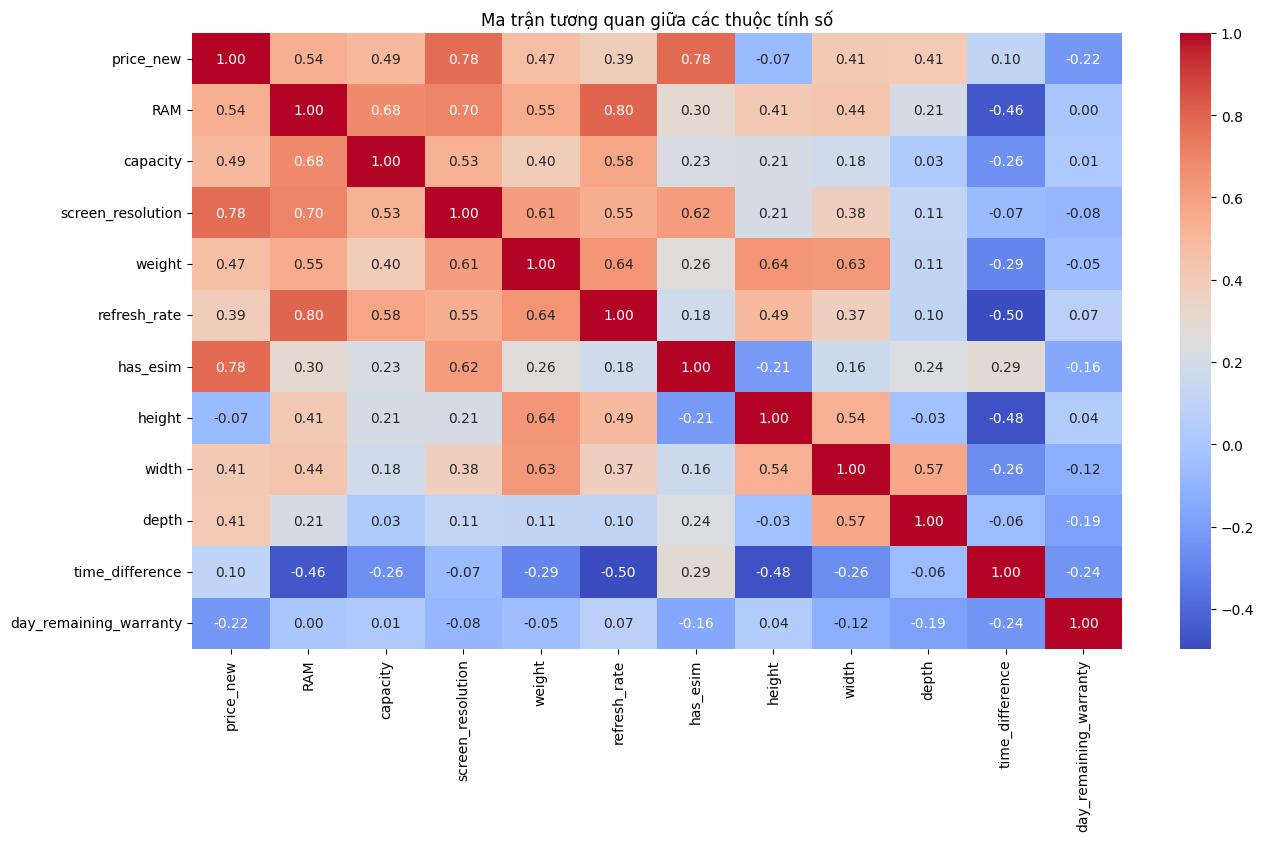

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_data = data.select_dtypes(include=np.number).drop('price_old', axis=1)

correlation_matrix = numeric_data.corr(method='pearson')
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan giữa các thuộc tính số")
plt.show()

In [98]:
# Ngưỡng tương quan
correlation_threshold = 0.8

# Lọc các cặp có độ tương quan cao
corr_series = correlation_matrix.unstack()
high_corr_pairs = corr_series[
    (corr_series.abs() > correlation_threshold) &
    (corr_series.abs() < 1.0)
]

high_corr_pairs = high_corr_pairs.sort_values(ascending=False, key=abs)
print(f"Các cặp thuộc tính có độ tương quan tuyệt đối > {correlation_threshold}:")
printed_pairs = set()
for (col1, col2), corr_value in high_corr_pairs.items():
    pair = tuple(sorted((col1, col2)))
    if pair not in printed_pairs:
        print(f"  - Cặp: {col1} - {col2}, Tương quan: {corr_value:.3f}")
        printed_pairs.add(pair)

Các cặp thuộc tính có độ tương quan tuyệt đối > 0.8:


In [82]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Tính VIF cho từng thuộc tính
X = add_constant(numeric_data)

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data[vif_data['feature'] != 'const']

print("Kết quả VIF cho các thuộc tính số:")
print(vif_data.sort_values(by='VIF', ascending=False))

Kết quả VIF cho các thuộc tính số:
                   feature         VIF
8             has_nano_sim  422.355391
3                  battery   14.365190
4              screen_size    9.522396
0                price_new    8.360735
1                      RAM    6.460976
6                   weight    6.362903
5        screen_resolution    5.002618
10                  height    4.771506
9                 has_esim    4.125035
11                   width    3.837967
7             refresh_rate    3.830167
12                   depth    2.698781
13         time_difference    2.697016
2                 capacity    2.500029
14  day_remaining_warranty    1.175257


In [83]:
data = data.drop(columns = ['has_nano_sim', 'battery', 'screen_size'])

Drop những thuộc tính VIF lớn 10 và có tương quan tuyệt đối > 0.8.

# Encoding

## Xử lí operating system

Phân loại theo mức độ cập nhật hệ điều hành.

In [100]:
def get_update_score(os_name):
    if os_name.startswith("iOS"):
        match = re.search(r"iOS\s*(\d+)", os_name)
        if match:
            version = int(match.group(1))
            return version / 18
        return np.nan
    elif os_name.startswith("Android"):
        match = re.search(r"Android\s*(\d+)", os_name)
        if match:
            version = int(match.group(1))
            return version / 15
        return np.nan
    else:
        return np.nan

# Tính điểm cập nhật
data['update_score'] = data['operating_system'].apply(get_update_score)

# Gán NaN bằng giá trị trung bình
mean_score = data['update_score'].mean()
data['update_score'].fillna(mean_score, inplace=True)

# Gán lại vào cột operating_system
data['operating_system'] = data['update_score']

# Xoá cột phụ
data.drop(columns=['update_score'], inplace=True)


C:\Users\PC\AppData\Local\Temp\ipykernel_4132\3561700581.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['update_score'].fillna(mean_score, inplace=True)


## Xử lí CPU

Gom nhóm CPU dựa trên hiệu năng

In [104]:
# High performance
high = data['CPU'].str.contains(
    r'(?i)(?:a18|a17|a16|a15(?:\sbionic)?|snapdragon\s8(?:\sgen\s3|\sgen\s2|\+?\sgen\s1)|8\selite|exynos\s2400(?:e)?|exynos\s2200|dimensity\s(?:9300\+|9400|9200|8300))',
    na=False
)
# Mid performance
mid = data['CPU'].str.contains(
    r'(?i)(?:a14(?:\sbionic)?|a13(?:\sbionic)?|snapdragon\s(?:7(?:\sgen\s[13]|s\sgen\s2)|6\sgen\s[134]|6s\s(?:gen\s1|4g\sgen\s1))|exynos\s(?:2100|15[80]|14[80]|13[80]|1280)|dimensity\s(?:1080|7050|7025|7300|6300|6100\+|6020|700|8350|d6300))',
    na=False
)
# Low performance
low = data['CPU'].str.contains(
    r'(?i)(?:snapdragon\s(?:6[895]|680(?:\s4g)?|sm6225)|helio\s(?:g(?:99|96|92|91|88|85|81|36|35)|p35|g100)|mt6762|unisoc\s(?:t(?:7250|7225|615|612|606|107)|ums9117)|tiger\s?t693)',
    na=False
)
# Default for non-matching or missing values
conditions = [high, mid, low]
choices = ['3', '2', '1']  # 3: High, 2: Mid, 1: Low

data['CPU'] = np.select(conditions, choices, default='1').astype(int)

## Xử lí display technology

Phân loại thành 3 công nghệ chính: LCD, OLED, và hybrid

In [108]:
LCD = data['display_technology'].str.lower().str.contains(
    'lcd|tn|liquid', na=False)

OLED = data['display_technology'].str.lower().str.contains(
    'oled|amoled|super retina xdr', na=False)

no_display_technology = data['display_technology'].isna() | (data['display_technology'].str.lower() == 'unknown')

conditions = [no_display_technology, LCD, OLED]
choices = ['1', '2', '3']

data['display_technology'] = np.select(conditions, choices, default='1')
data['display_technology'] = pd.to_numeric(data['display_technology'])

## Xử lí condition

Gắn nhãn thủ công cho tình trạng của máy

In [112]:
# Định nghĩa các tình trạng và nhãn số tương ứng của chúng
condition_mapping = {
    'Cũ trầy xước cấn': 1,
    'Cũ trầy xước': 2,
    'Cũ': 3,
    'Cũ đẹp': 4,
}

# Ánh xạ mô tả thành các nhãn
data['condition'] = data['condition'].map(condition_mapping)

## Xử lí brand

Gắn nhãn thủ công cho nhãn dựa trên mức độ phổ biến và phân khúc thị trường của thương hiệu

In [116]:
print(data['brand'].unique())

['apple' 'samsung' 'oppo' 'realme' 'xiaomi' 'vivo' 'tecno' 'honor'
 'masstel' 'mobell' 'nokia']


In [118]:
# Định nghĩa thương hiệu và nhãn số tương ứng của chúng
brand_mapping = {
    'apple': 4,
    'samsung': 4,

    'honor': 3,
    'oppo': 3,
    'xiaomi': 3,
    'vivo': 3,
    
    'realme': 2,
    'tecno': 2,
    'nokia': 2,
    'tcl': 2,

    'mobell': 1,
    'viettel': 1,
    'masstel': 1
}

# Ánh xạ nhãn cho cột 'brand'
data['brand'] = data['brand'].map(brand_mapping)

## Xử lí name và color

Dùng LabelEncoder để encode cho name và color

In [122]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['name'] = label_encoder.fit_transform(data['name'])
data['color'] = label_encoder.fit_transform(data['color'])

In [123]:
data['color'].nunique()

51

## Xử lí GPU

Dựa vào hiệu năng để gắn nhãn cho các dòng GPU

In [128]:
high_cond = data['GPU'].str.lower().str.contains(
    'adreno-7|adreno-8|mali-g7|mali-g76|mali-g77|mali-g78|apple-gpu 6|apple-gpu 5|immortalis|xclipse|powervr-series7xt', na=False)

low_cond = data['GPU'].str.lower().str.contains(
    'adreno-6|adreno-5|adreno-4|mali-g6|mali-g57|mali-g68|mali-g52|powervr-ge8320|xclipse-920|apple-gpu 4|adreno-619|adreno-644|adreno-670', na=False)

no_gpu_cond = data['GPU'].isna() | (data['GPU'].str.lower() == 'unknown')

conditions = [no_gpu_cond, high_cond, low_cond]
choices = ['1', '3', '2']

data['GPU'] = np.select(conditions, choices, default='1')
data['GPU'] = pd.to_numeric(data['GPU'])


## Xử lí bluetooth

Dựa vào phiên bản và các tính năng để gắn trọng số

In [132]:
# Bảng điểm version
version_score_map = {
    '2.1': 1.0,
    '4.2': 2.0,
    '5.0': 3.0,
    '5.1': 3.2,
    '5.2': 3.4,
    '5.3': 3.6,
    '5.4': 3.8,
    '6.0': 4.0
}

# Trọng số profile
profile_points = {
    'apt-X Adaptive': 0.2,
    'apt-X HD': 0.15,
    'LHDC': 0.15,
    'apt-X': 0.1,
    'A2DP': 0.1,
    'LE': 0.1,
    'BLE': 0.05
}

# Hàm mã hóa
def encode_bluetooth_weighted(bluetooth_str):
    if pd.isna(bluetooth_str):
        return np.nan

    # Tìm version
    version_match = re.findall(r'v(\d\.\d)', bluetooth_str)
    version = version_score_map.get(version_match[0], 0) if version_match else 0

    # Tính điểm profile
    profile_score = sum(pt for profile, pt in profile_points.items() if profile in bluetooth_str)

    return round(version + profile_score, 2)

# Áp dụng vào cột
data['bluetooth'] = data['bluetooth'].apply(encode_bluetooth_weighted)

# Chọn thuộc tính

In [135]:
# Lấy ra tất cả các cột có kiểu dữ liệu là số
numerical_cols = data.select_dtypes(include=np.number).columns.tolist()

# Độ tương quan Spearman của các thuộc tính số
correlation_matrix = data[numerical_cols].corr(method='spearman')
target_column = 'price_old'

# Sắp xếp và hiển thị kết quả
correlation_with_target = correlation_matrix[target_column]
correlation_spearman_filtered = correlation_with_target.drop(target_column, errors='ignore').dropna()
sorted_correlation = correlation_spearman_filtered.sort_values(ascending=False)
print(f"Độ tương quan Spearman của '{target_column}' với các thuộc tính khác (sắp xếp giảm dần):")
print(sorted_correlation)

Độ tương quan Spearman của 'price_old' với các thuộc tính khác (sắp xếp giảm dần):
price_new                 0.982289
CPU                       0.899716
screen_resolution         0.830835
has_esim                  0.803328
display_technology        0.794316
GPU                       0.776636
brand                     0.664016
capacity                  0.600109
RAM                       0.588368
refresh_rate              0.480140
bluetooth                 0.465480
weight                    0.328143
operating_system          0.274455
condition                 0.100662
width                     0.079110
time_difference           0.013743
name                     -0.123469
day_remaining_warranty   -0.162686
depth                    -0.163601
color                    -0.237289
height                   -0.440362
Name: price_old, dtype: float64


In [137]:
# Lọc các thuộc tính có độ tương quan dưới 0.05
low_correlation_features = sorted_correlation[abs(sorted_correlation) < 0.05]

print("Các thuộc tính có độ tương quan Spearman dưới 0.05:")
print(low_correlation_features)


Các thuộc tính có độ tương quan Spearman dưới 0.05:
time_difference    0.013743
Name: price_old, dtype: float64


In [139]:
from sklearn.feature_selection import f_classif

# Tách features (X) và target (y)
X = data.select_dtypes(include=['number']).drop(columns=['price_old'])
X = X.fillna(0)
y = data['price_old']

# Tính ANOVA F-test
f_values, p_values = f_classif(X, y)

# Gộp kết quả vào một DataFrame
anova_results = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_values,
    'p-Value': p_values
})

# Sắp xếp theo F-Score giảm dần
anova_results = anova_results.sort_values(by='F-Score', ascending=False)

print(anova_results)

                   Feature     F-Score  p-Value
3                price_new  722.619305      0.0
18                   depth  289.325928      0.0
17                   width  254.070680      0.0
4                      CPU  212.947880      0.0
16                  height  140.328732      0.0
9        screen_resolution  137.350366      0.0
10                  weight  134.889525      0.0
15                has_esim  115.324676      0.0
8       display_technology   98.996283      0.0
5                      RAM   96.254641      0.0
13                     GPU   95.907558      0.0
12            refresh_rate   66.678685      0.0
1                    brand   61.075041      0.0
11               bluetooth   58.763688      0.0
7         operating_system   52.101811      0.0
6                 capacity   47.791967      0.0
0                     name   42.557637      0.0
20  day_remaining_warranty   34.451316      0.0
19         time_difference   30.957998      0.0
2                condition   12.708085  

In [141]:
# Lọc các thuộc tính có p-value trên 0.05
anova_filtered = anova_results[abs(anova_results['p-Value']) > 0.05]

print("Các thuộc tính có giá trị p lớn hơn 0.05:")
print(anova_filtered)


Các thuộc tính có giá trị p lớn hơn 0.05:
Empty DataFrame
Columns: [Feature, F-Score, p-Value]
Index: []


Chuyển đổi đơn vị của price old và price new từ đồng sang ngàn đồng

In [144]:
data['price_old'] = data['price_old']/1000
data['price_new'] = data['price_new']/1000

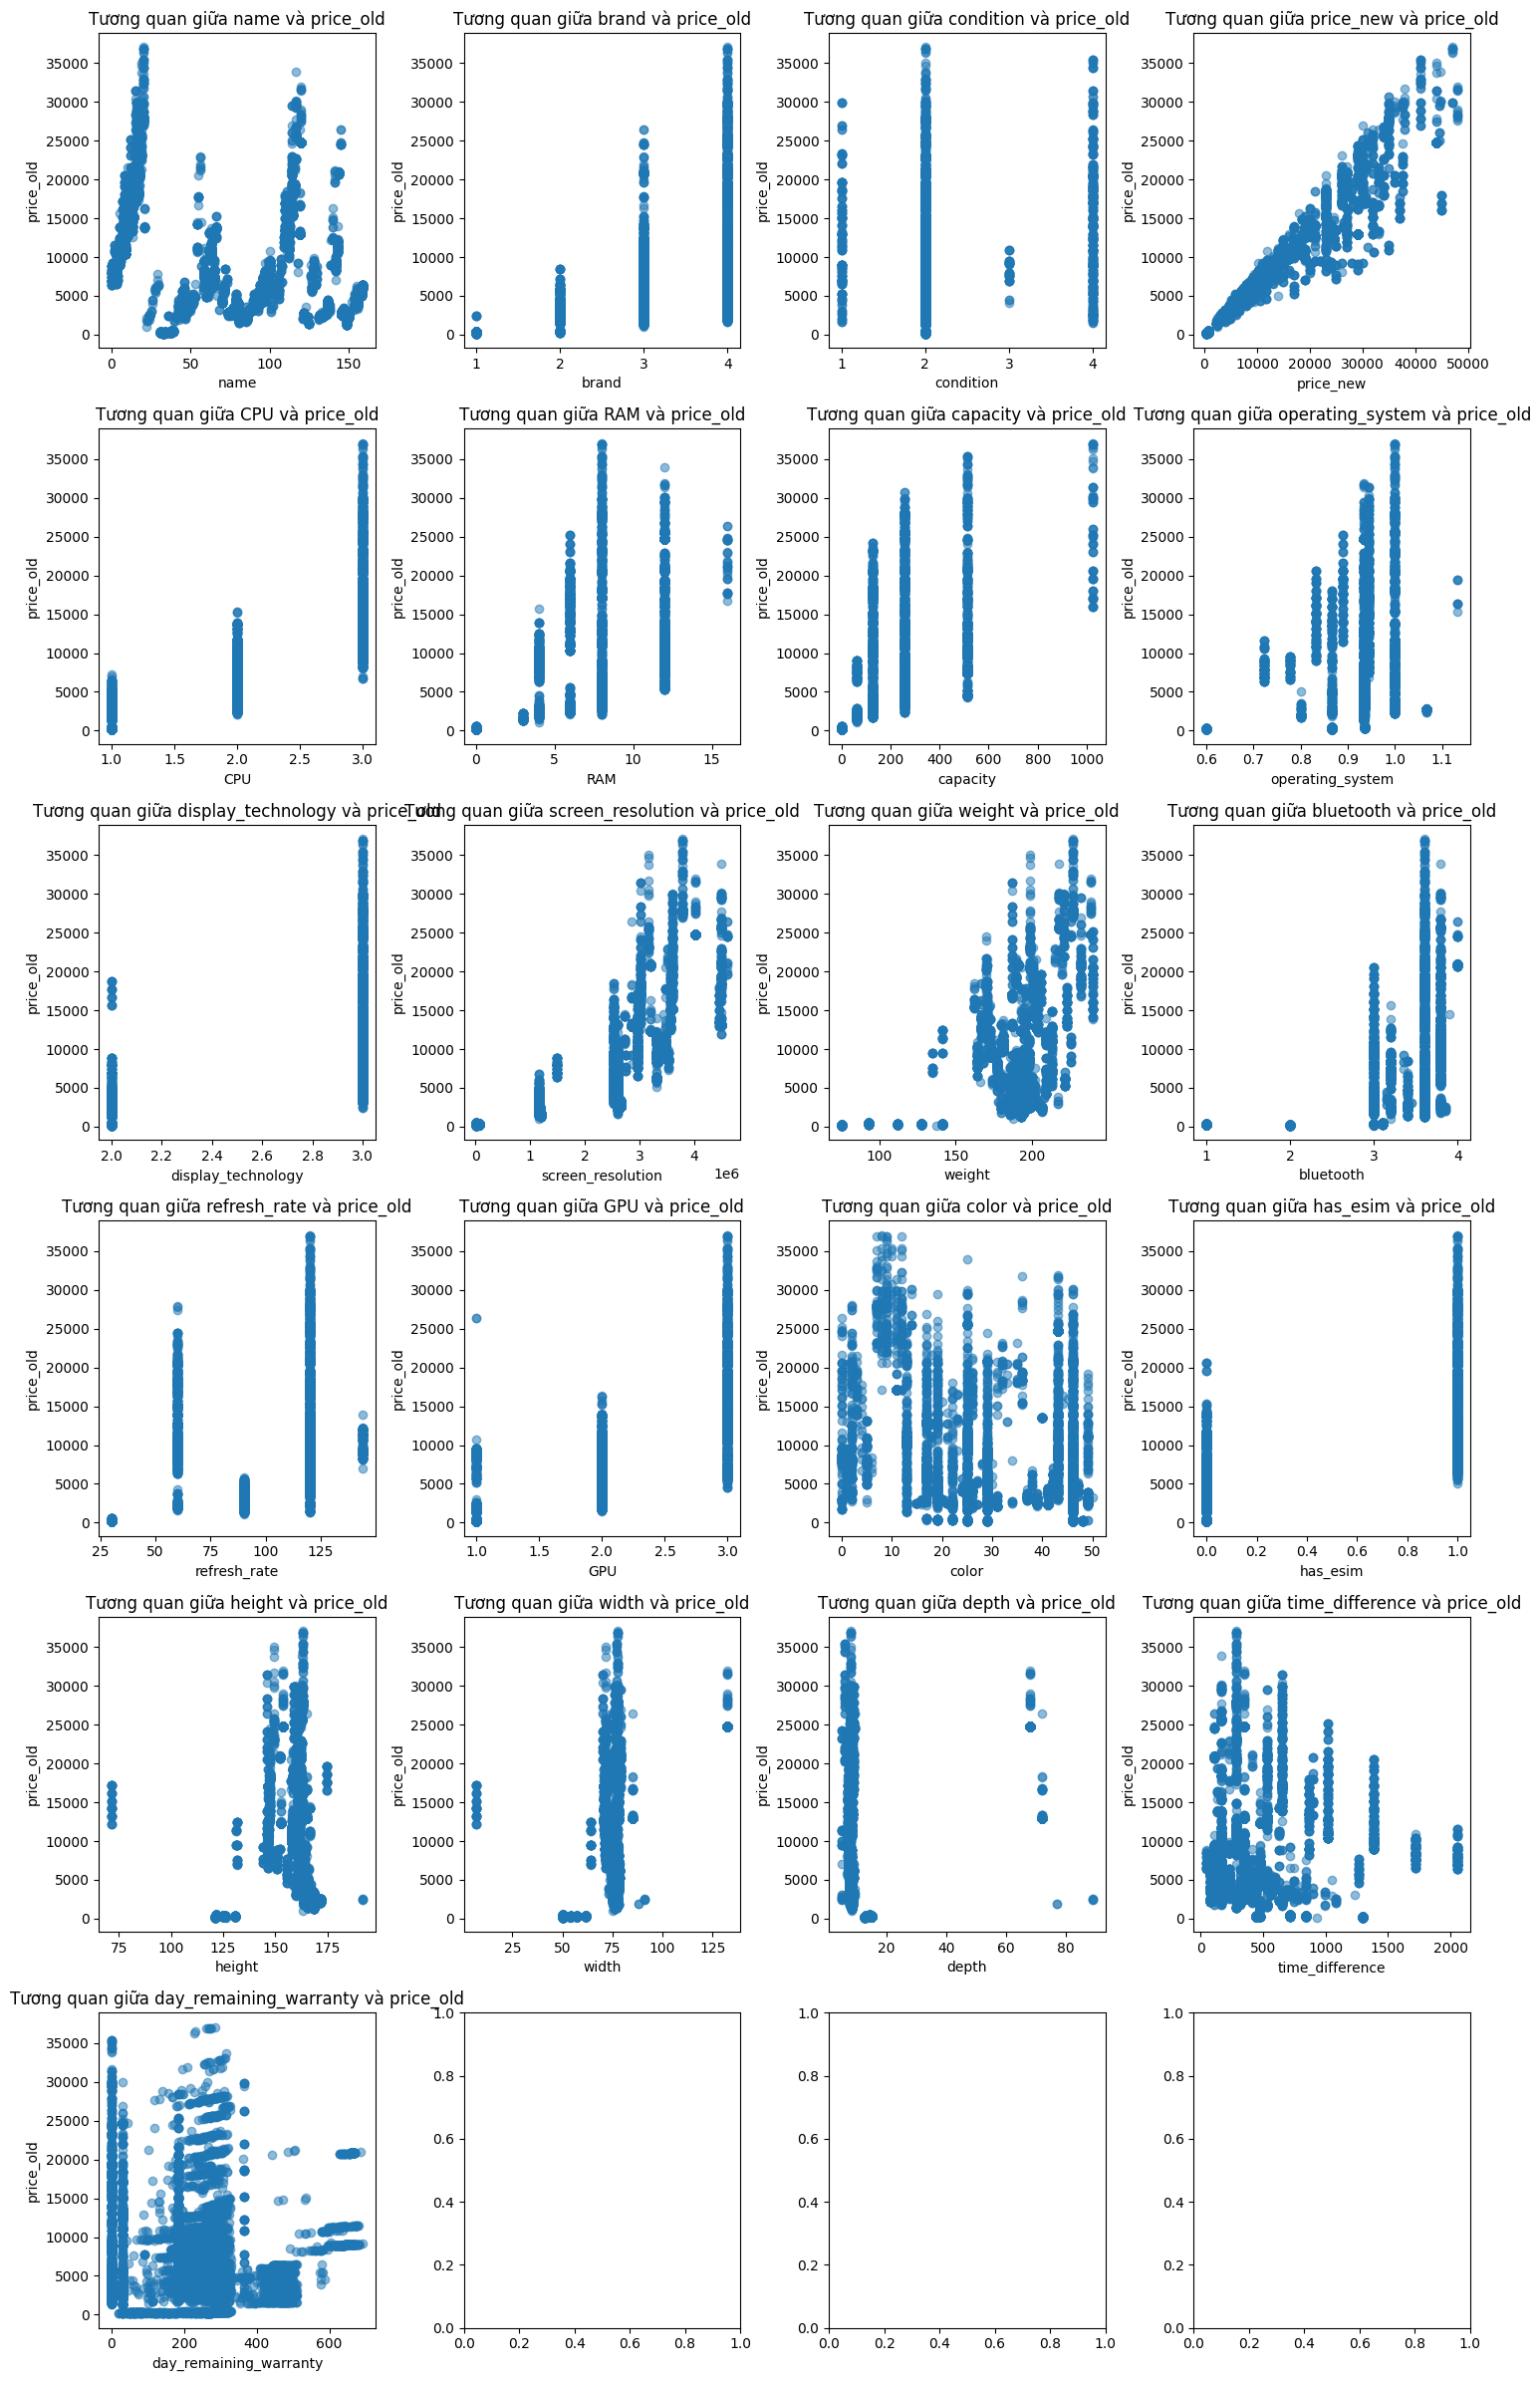

In [146]:
import matplotlib.pyplot as plt

# Lấy danh sách các cột số, ngoại trừ price_old
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove("price_old")  # Loại bỏ target khỏi danh sách

# Xác định số hàng phù hợp
num_plots = len(numerical_cols)
ncols = 4  # Số cột cố định
nrows = (num_plots // ncols) + (1 if num_plots % ncols != 0 else 0)  # Điều chỉnh số hàng

# Vẽ biểu đồ scatter
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 4))
axes = axes.flatten()[:num_plots]  # Chỉ lấy đủ số subplot cần thiết

for i, col in enumerate(numerical_cols):
    axes[i].scatter(data[col], data["price_old"], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("price_old")
    axes[i].set_title(f"Tương quan giữa {col} và price_old")

# Ẩn các subplot thừa (nếu có)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [147]:
data = data.drop(columns=['color', 'day_remaining_warranty'])

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Khởi tạo mô hình K-Means với k cụm
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)

# Huấn luyện mô hình
kmeans.fit(np.array(data))

# Nhận nhãn cụm và tâm cụm
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print("Nhóm:", labels)
print("Tâm cụm:", centroids)

In [ ]:
data_clustered = pd.DataFrame(data)
data_clustered["Cluster"] = labels

# Hiển thị danh sách price_old theo từng cụm
print(data_clustered.groupby("Cluster")["price_old"].describe())


In [ ]:
import matplotlib.pyplot as plt

# Lấy danh sách các cột số (ngoại trừ price_old)
numerical_cols = data_clustered.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove("price_old")  # Loại bỏ target khỏi danh sách

# Vẽ tất cả các biểu đồ scatter
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, len(numerical_cols)))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].scatter(data_clustered[col], data["price_old"], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("price_old")
    axes[i].set_title(f"Tương quan giữa {col} và price_old")

plt.tight_layout()
plt.show()

In [ ]:
data_clustered.duplicated().sum()

In [ ]:
data_clustered = data_clustered.drop_duplicates()

In [ ]:
data_clustered.shape

# Chia tập dữ liệu

In [ ]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập huấn luyện và tập dev + test theo tỷ lệ 60:40
X_train, X_temp, y_train, y_temp = train_test_split(data_clustered.drop(columns=['price_old']), data_clustered["price_old"], test_size=0.4, random_state=42)

# Chia tiếp tập dev + test thành tập dev (20%) và tập test (20%)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


## Lưu các dữ liệu sau chia tập

In [ ]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data.to_csv("train.csv")

In [ ]:
dev_data = pd.concat([X_dev, y_dev], axis=1)
dev_data.to_csv("dev.csv")

In [ ]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv("test.csv")

# Huấn luyện mô hình

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

## XGBRegressor

In [ ]:
from xgboost import XGBRegressor

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

xgb = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

print("Các siêu tham số tối ưu: ", xgb.best_params_)
print("MSE tốt nhất:", -xgb.best_score_)
print("RMSE tốt nhất:", np.sqrt(-xgb.best_score_))


In [ ]:
xgb_regressor = xgb.best_estimator_

# Huấn luyện mô hình trên tập train
xgb_regressor.fit(X_train, y_train)

# Dự đoán trên tập dev
y_pred_xgb = xgb_regressor.predict(X_dev)

# Đánh giá mô hình bằng MSE và RMSE trên tập dev
mse_dev = mean_squared_error(y_dev, y_pred_xgb)
rmse_dev = np.sqrt(mse_dev)
mape = mean_absolute_percentage_error(y_dev, y_pred_xgb)
r2 = r2_score(y_dev, y_pred_xgb)

print(f"MSE trên tập dev: {mse_dev}")
print(f"RMSE trên tập dev: {rmse_dev}")
print(f"MAPE trên tập dev: {mape}")
print(f"R² trên tập dev: {r2:.4f}")

In [ ]:
# Lấy và hiển thị độ quan trọng của từng đặc trưng
df_importance = pd.DataFrame({'Feature': X_train.columns,
                              'Importance': xgb_regressor.feature_importances_}).sort_values(by='Importance', ascending=False)

# Trực quan hóa
plt.barh(df_importance['Feature'], df_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for XGBRegressor')
plt.show()


## LGBMRegressor

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Tìm số lượng cây tối ưu cho mô hình bởi Early Stopping
lgbm = LGBMRegressor(
    objective='regression',
    n_estimators=5000,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=20,
    random_state=42
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(
        stopping_rounds=50,
        verbose=False
    )],
)

# Số lượng cây tối ưu được chọn bởi Early Stopping
n = lgbm.best_iteration_
print(f"\nSố lượng cây tối ưu (n_estimators) được chọn bởi Early Stopping: {lgbm.best_iteration_}")

In [ ]:
# Định nghĩa không gian tham số (param_grid)
param_grid = {
    'n_estimators': [n],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 10, 20],
}

lgbm = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

# Lấy kết quả tốt nhất
print("Tham số tốt nhất:", lgbm.best_params_)
print("MSE tốt nhất:", -lgbm.best_score_)
print("RMSE tốt nhất:", np.sqrt(-lgbm.best_score_))

In [ ]:
# Khởi tạo mô hình với các tham số được tinh chỉnh
lgbm_regressor = lgbm.best_estimator_

# Huấn luyện
lgbm_regressor.fit(X_train, y_train)

# Dự đoán
y_pred_lgbm = lgbm_regressor.predict(X_dev)

# Đánh giá mô hình bằng MSE và RMSE trên tập dev
mse_dev = mean_squared_error(y_dev, y_pred_lgbm)
rmse_dev = np.sqrt(mse_dev)
mape = mean_absolute_percentage_error(y_dev, y_pred_lgbm)
r2 = r2_score(y_dev, y_pred_lgbm)

print(f"MSE trên tập dev: {mse_dev}")
print(f"RMSE trên tập dev: {rmse_dev}")
print(f"MAPE trên tập dev: {mape}")
print(f"R² trên tập dev: {r2:.4f}")

In [ ]:
# Lấy và hiển thị độ quan trọng của từng đặc trưng
df_importance = pd.DataFrame({'Feature': X_train.columns,
                              'Importance': lgbm_regressor.feature_importances_}).sort_values(by='Importance', ascending=False)

# Trực quan hóa
plt.barh(df_importance['Feature'], df_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for LGBMRegressor')
plt.show()

## RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Thiết lập grid search với các giá trị siêu tham số cần thử nghiệm
param_grid = {
    "n_estimators": [100, 200, 300],  # Số lượng cây trong rừng
    "max_depth": [None, 10, 20],      # Độ sâu tối đa của cây
    "min_samples_split": [2, 5, 10],  # Số mẫu tối thiểu để chia nút
    "min_samples_leaf": [1, 2, 4],    # Số mẫu tối thiểu ở nút lá
    "max_features": ["sqrt", "log2"]  # Số lượng đặc trưng được chọn ngẫu nhiên
}

# Grid Search với cross-validation 5-fold
rf= GridSearchCV(RandomForestRegressor(random_state=42),
                param_grid = param_grid,
                cv=5,
                scoring="neg_root_mean_squared_error",
                n_jobs=-1,
                verbose=2)

# Huấn luyện
rf.fit(X_train, y_train)

# Kết quả tốt nhất
print("Tham số tốt nhất:", rf.best_params_)
print("MSE tốt nhất:", -rf.best_score_)
print("RMSE tốt nhất:", np.sqrt(-rf.best_score_))

In [ ]:
rf_regressor = rf.best_estimator_

# Dự đoán
y_pred_rf = rf_regressor.predict(X_dev)

# Đánh giá mô hình bằng MSE và RMSE trên tập dev
mse_dev = mean_squared_error(y_dev, y_pred_rf)
rmse_dev = np.sqrt(mse_dev)
mape = mean_absolute_percentage_error(y_dev, y_pred_rf)
r2 = r2_score(y_dev, y_pred_rf)

print(f"MSE trên tập dev: {mse_dev}")
print(f"RMSE trên tập dev: {rmse_dev}")
print(f"MAPE trên tập dev: {mape}")
print(f"R² trên tập dev: {r2:.4f}")

In [ ]:
# Lấy và hiển thị độ quan trọng của từng đặc trưng
df_importance = pd.DataFrame({'Feature': X_train.columns,
                              'Importance': rf_regressor.feature_importances_}).sort_values(by='Importance', ascending=False)

# Trực quan hóa
plt.barh(df_importance['Feature'], df_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for RandomForestRegressor')
plt.show()

## CatBoostRegressor

In [ ]:
from catboost import CatBoostRegressor

# Định nghĩa không gian tham số
param_dist = {
    'iterations': randint(100, 1000),
    'learning_rate': uniform(loc=0.01, scale=0.15),
    'depth': randint(4, 10),
    'l2_leaf_reg': uniform(loc=1, scale=5),
}

# Khởi tạo mô hình CatBoostRegressor
cat_model_base = CatBoostRegressor(
    random_state=42,
    loss_function='RMSE',
    eval_metric='R2',
    early_stopping_rounds=50,
    verbose=0,
)

# Khởi tạo RandomizedSearchCV
random_search_catboost = RandomizedSearchCV(estimator=cat_model_base,
                                            param_distributions=param_dist,
                                            n_iter=30,
                                            cv=5,
                                            scoring='r2',
                                            verbose=1,
                                            random_state=42,
                                            n_jobs=-1)

# Huấn luyện mô hình CatBoost với RandomizedSearchCV
random_search_catboost.fit(X_train, y_train,
                           eval_set=(X_dev, y_dev),
                           early_stopping_rounds=50,
                           verbose=100
                           )

# Kết quả tốt nhất
print("Tham số tốt nhất:", random_search_catboost.best_params_)
print("MSE tốt nhất:", random_search_catboost.best_score_)
print("RMSE tốt nhất:", np.sqrt(random_search_catboost.best_score_))

In [ ]:
# Lấy mô hình CatBoost tốt nhất đã được huấn luyện
cb_regressor = random_search_catboost.best_estimator_

# Dự đoán trên tập dev
y_pred_cb = cb_regressor.predict(X_dev)

# Đánh giá mô hình bằng MSE và RMSE trên tập dev
mse_dev = mean_squared_error(y_dev, y_pred_cb)
rmse_dev = np.sqrt(mse_dev)
mape = mean_absolute_percentage_error(y_dev, y_pred_cb)
r2 = r2_score(y_dev, y_pred_cb)

print(f"MSE trên tập dev: {mse_dev}")
print(f"RMSE trên tập dev: {rmse_dev}")
print(f"MAPE trên tập dev: {mape}")
print(f"R² trên tập dev: {r2:.4f}")

In [ ]:
# Lấy và hiển thị độ quan trọng của từng đặc trưng
df_importance = pd.DataFrame({'Feature': X_train.columns,
                              'Importance': cb_regressor.feature_importances_}).sort_values(by='Importance', ascending=False)

# Trực quan hóa
plt.barh(df_importance['Feature'], df_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for CatBoostRegressor')
plt.show()

# Kiểm định

## XGBRegressor

In [ ]:
# Dự đoán
y_pred_xgb = xgb_regressor.predict(X_test)

# Đánh giá mô hình bằng MSE và RMSE trên tập test
mse_test = mean_squared_error(y_test, y_pred_xgb)
rmse_test = np.sqrt(mse_test)
mape = mean_absolute_percentage_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print(f"MSE trên tập test: {mse_test}")
print(f"RMSE trên tập test: {rmse_test}")
print(f"MAPE trên tập test: {mape}")
print(f"R² trên tập test: {r2:.4f}")

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect prediction")
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title("XGBRegressor")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

## LGBM Regressor

In [ ]:
# Dự đoán
y_pred_lgbm = lgbm_regressor.predict(X_test)

# Đánh giá mô hình bằng MSE và RMSE trên tập test
mse_test = mean_squared_error(y_test, y_pred_lgbm)
rmse_test = np.sqrt(mse_test)
mape = mean_absolute_percentage_error(y_test, y_pred_lgbm)
r2 = r2_score(y_test, y_pred_lgbm)

print(f"MSE trên tập test: {mse_test}")
print(f"RMSE trên tập test: {rmse_test}")
print(f"MAPE trên tập test: {mape}")
print(f"R² trên tập test: {r2:.4f}")

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lgbm, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect prediction")
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title("LGBMRegressor")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

## RandomForestRegressor

In [ ]:
# Dự đoán
y_pred_rf = rf_regressor.predict(X_test)

# Đánh giá mô hình bằng MSE và RMSE trên tập test
mse_test = mean_squared_error(y_test, y_pred_rf)
rmse_test = np.sqrt(mse_test)
mape = mean_absolute_percentage_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"MSE trên tập test: {mse_test}")
print(f"RMSE trên tập test: {rmse_test}")
print(f"MAPE trên tập test: {mape}")
print(f"R² trên tập test: {r2:.4f}")

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect prediction")
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title("RandomForestRegressor")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

## CatBoostRegressor

In [ ]:
# Dự đoán
y_pred_cb = cb_regressor.predict(X_test)

# Đánh giá mô hình bằng MSE và RMSE trên tập test
mse_test = mean_squared_error(y_test, y_pred_cb)
rmse_test = np.sqrt(mse_test)
mape = mean_absolute_percentage_error(y_test, y_pred_cb)
r2 = r2_score(y_test, y_pred_cb)

print(f"MSE trên tập test: {mse_test}")
print(f"RMSE trên tập test: {rmse_test}")
print(f"MAPE trên tập test: {mape}")
print(f"R² trên tập test: {r2:.4f}")

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_cb, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect prediction")
plt.xlabel("Thực tế")
plt.ylabel("Dự đoán")
plt.title("CatBoostRegressor")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()

# Lưu mô hình

In [ ]:
import joblib

joblib.dump(xgb_regressor, 'xgb_model.pkl')
joblib.dump(lgbm_regressor, 'lgbm_model.pkl')
joblib.dump(rf_regressor, 'rf_model.pkl')
joblib.dump(cb_regressor, 'cb_model.pkl')